In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df = pd.read_csv('./datasets/DJI.csv', header=0, index_col=0)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,25336.67,25402.83,25290.20,25322.31,"276,743,816"
6/12/2018,25346.82,25364.37,25247.04,25320.73,"265,748,474"
6/13/2018,25328.65,25362.07,25191.42,25201.20,"329,699,709"
6/14/2018,25254.65,25332.50,25138.60,25175.31,"341,168,401"
6/15/2018,25116.71,25130.82,24894.38,25090.48,"659,373,330"


<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1250 non-null   float64
 1   High    1250 non-null   float64
 2   Low     1250 non-null   float64
 3   Close   1250 non-null   float64
 4   Volume  1250 non-null   object 
dtypes: float64(4), object(1)
memory usage: 58.6+ KB


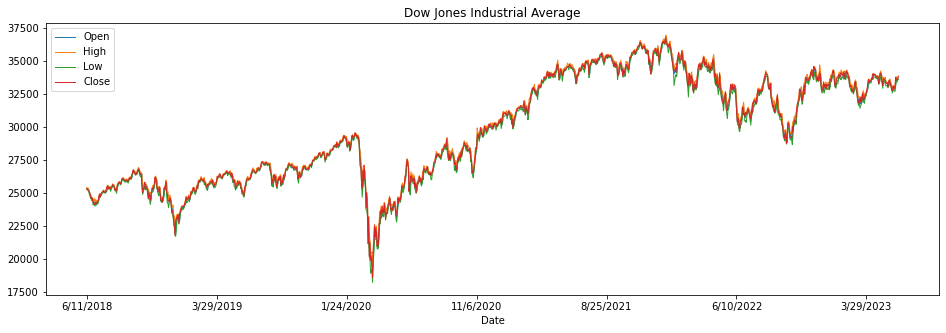

In [4]:
df.info()
df.plot(figsize=(16,5),lw=1, title="Dow Jones Industrial Average")
plt.show()

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 1250 entries, 6/11/2018 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1250 non-null   float64
dtypes: float64(1)
memory usage: 19.5+ KB


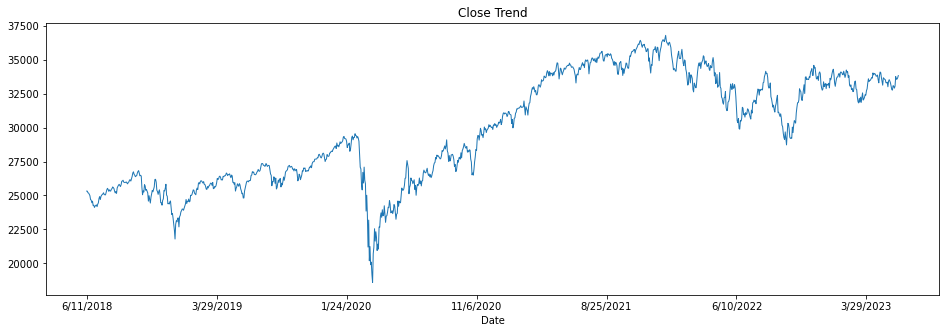

In [5]:
df_close = df["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Standardizing Close dataset

<AxesSubplot:xlabel='Date'>

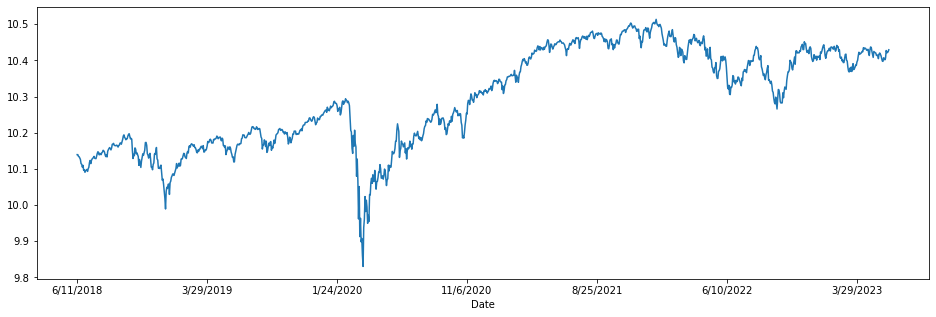

In [275]:
# Perform data transformation or standardization using log
df_close = np.log(df_close) # Don't forget to transform the data back when making real prediction
df_close.plot(figsize=(16,5))

### Split data for train and test

In [6]:
# Split the data for train and test
df_train = df_close[:1200].copy()
df_test = df_close[1200:].copy()

In [7]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

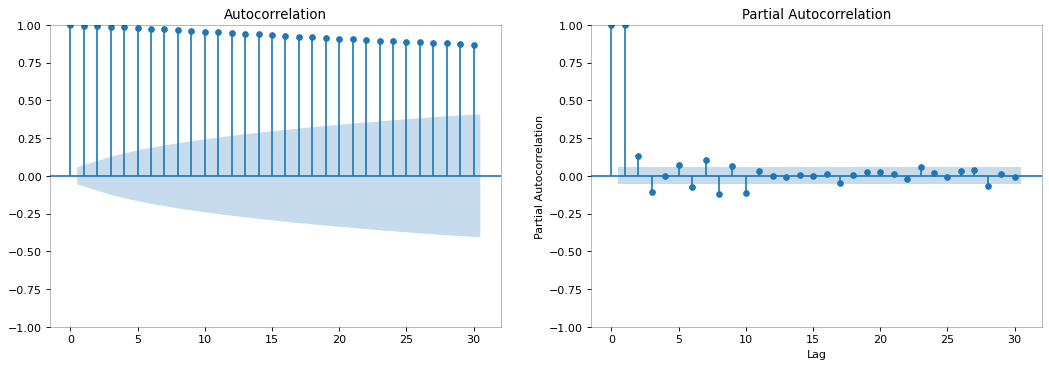

In [8]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [9]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [10]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -1.779670
p-value: 0.390601
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [13]:
from statsmodels.tsa.stattools import kpss

In [11]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [14]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            4.400461
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -119.52999999999884


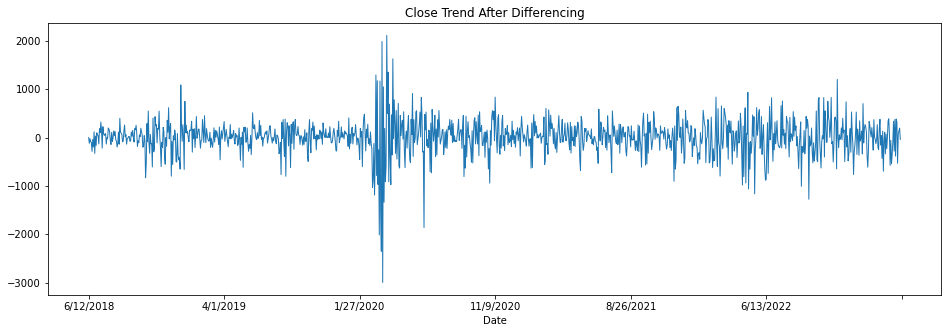

In [15]:
# Perform differencing
df_train_diff = df_train.diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

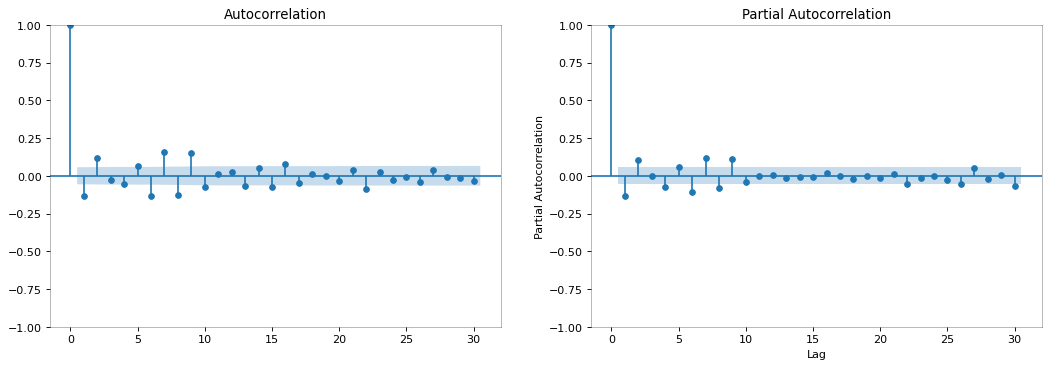

In [16]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [20]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [21]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=5, max_q=5,m=12,start_P=0,start_Q=0, 
                          max_P = 5, max_Q = 5,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18181.276, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17887.706, Time=0.99 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18170.624, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17719.108, Time=2.03 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=17657.590, Time=3.75 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=16.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.30 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=17676.623, Time=1.44 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=17643.375, Time=4.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17705.749, Time=2.41 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=21.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.01 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=17645.172, Time=5.26 sec
 ARIMA(2,1,1)(3,1,0)[12]        

## Fit the ARIMA Model

In [64]:
model = ARIMA(df_train, order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1200
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -8760.744
Date:                Thu, 15 Jun 2023   AIC                          17533.489
Time:                        13:53:39   BIC                          17564.024
Sample:                             0   HQIC                         17544.991
                               - 1200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4255      0.363      1.171      0.242      -0.287       1.138
ar.L2         -0.0149      0.226     -0.066      0.947      -0.457       0.427
ma.L1         -0.5358      0.364     -1.470      0.1

## Make time series prediction

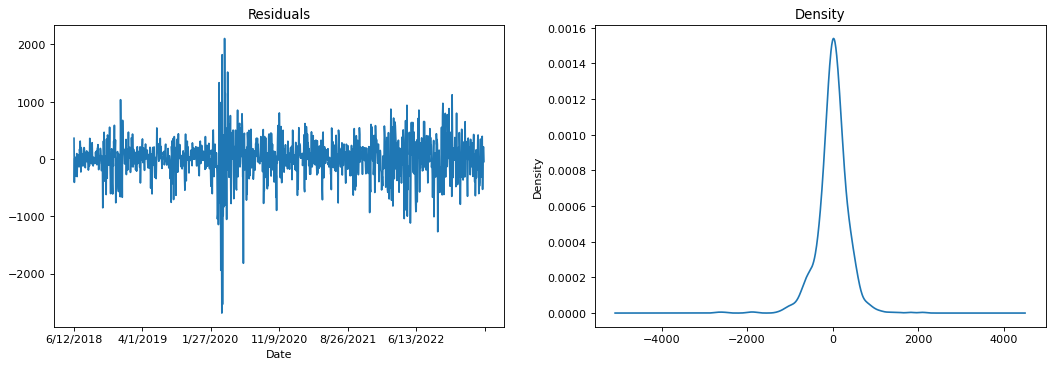

In [65]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

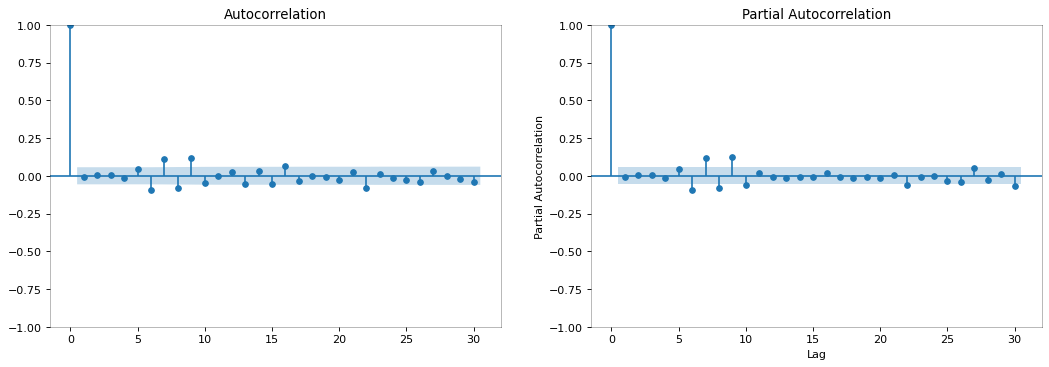

In [66]:
plot_correlation(residuals)

In [67]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [68]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
3/29/2023,32416.851036,32717.60
3/30/2023,32399.492433,32859.03
3/31/2023,32396.146920,33274.15
4/3/2023,32394.981907,33601.15
4/4/2023,32394.536013,33402.38
4/5/2023,32394.363634,33482.72
4/6/2023,32394.296926,33485.29
4/10/2023,32394.271109,33586.52
4/11/2023,32394.261117,33684.79


<AxesSubplot:xlabel='Date'>

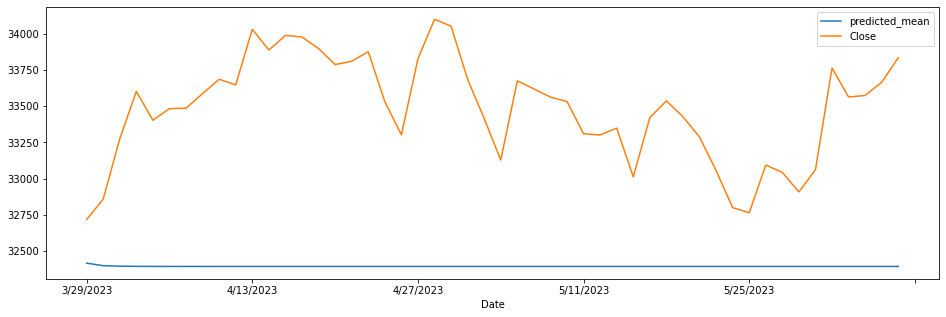

In [69]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [42]:
train = df_close[:1200].copy()
test = df_close[1200:].copy()

In [43]:
final_model = SARIMAX(train,order=(2,1,0),seasonal_order=(3,1,0,12)) # (2,1,0)(3,1,0)[12]  
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39867D+00    |proj g|=  4.09326D-02


 This problem is unconstrained.



At iterate    5    f=  7.39659D+00    |proj g|=  1.38362D-03

At iterate   10    f=  7.39480D+00    |proj g|=  2.90628D-02

At iterate   15    f=  7.35735D+00    |proj g|=  9.66395D-02

At iterate   20    f=  7.34641D+00    |proj g|=  9.44613D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     26      1     0     0   8.178D-06   7.346D+00
  F =   7.3464063493078928     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:               

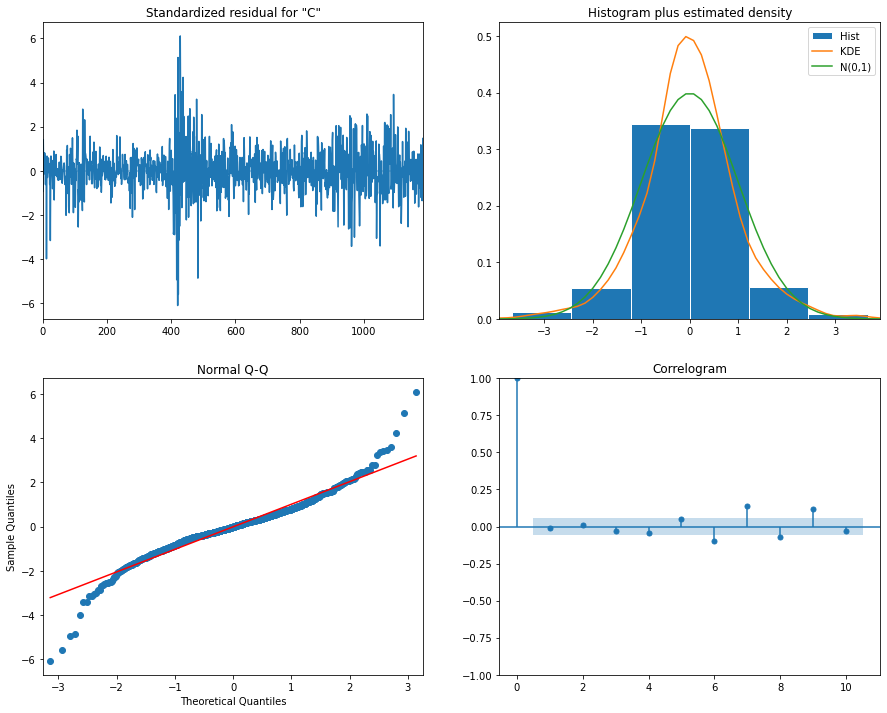

In [44]:
result.plot_diagnostics(figsize=(15, 12));

In [45]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# (2,1,0)(3,1,0)[12]  
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,0)(3,1,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [47]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(2,1,0)(3,1,0,12) Predictions",Close
Date,,
3/29/2023,32366.189444,32717.60
3/30/2023,32560.792055,32859.03
3/31/2023,32495.209379,33274.15
4/3/2023,32509.479007,33601.15
4/4/2023,32448.145944,33402.38
4/5/2023,32781.782529,33482.72
4/6/2023,32919.524488,33485.29
4/10/2023,32728.160780,33586.52
4/11/2023,32588.094105,33684.79


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

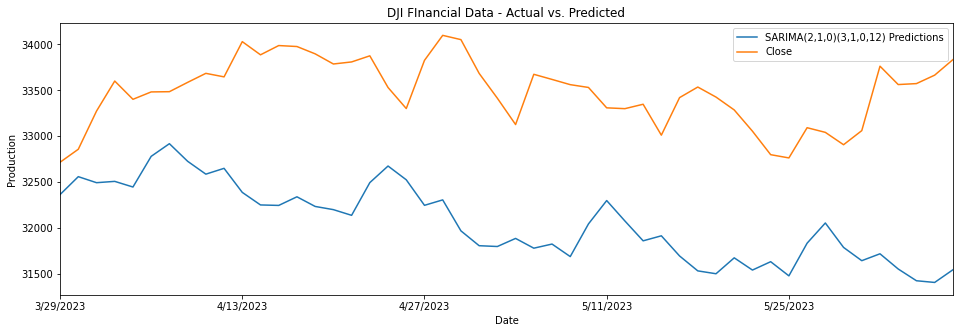

In [48]:
title = 'DJI FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)